##### Copyright 2019 The TensorFlow Authors.

In [92]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Lab DL 08: Model Transformer untuk Pemahaman Bahasa**
Nama : Muhammad Fikrizza

NIM  : 2000018096

# **1. Pendahuluan**

Modul Praktikum ini diadopsi dari Tutorial berjudul "Transformer Model for Language Understanding" dari Tensorflow.

## **1.1. Tujuan Praktikum**
Kegiatan praktikum ini bertujuan untuk menggunakan mekanisme *Self Attention* (Transformer) untuk mesin translasi Bahasa Portugis ke Bahasa Inggris.

## **1.2. Landasan Teori**

Teori tentang Transformer (*Self Attention*) dapat dilihat pada
[video berikut](https://https://www.youtube.com/watch?v=mRAAZfzTq5U)

Teori tentang Transformer juga dapat dilihat dari [link berikut](https://https://jalammar.github.io/illustrated-transformer/)



Praktikum ini akan membangun <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> untuk melakukan translasi bahasa Portugis ke Bahasa Inggris.

Ide dasar dari Transformer adalah *self-attention*— kemampuan untuk memberikan atensi pada berbagai posisi pada sekuens teks. Transformer menggunakan beberapa layer *self-attention* dan dijelaskan dibawah ini dalam  *Scaled dot product attention* dan  *Multi-head attention*.

Sebuah model transformer menghandle input yang bervariasi ukurannya dengan menggunakan layer-layer *self-attention* dari pada [RNNs](text_classification_rnn.ipynb) atau [CNNs](../images/intro_to_cnns.ipynb).

Arsitektur yanng memiliki layer-layer *self-attention* ini memiliki beberapa kelebihan, yaitu:

* Memiliki asumsi bahwa tidak ada hubungan spasial atau temporal pada data, sehingga transformer cocok diaplikasikan pada data object (seperti, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Komputasi Layer output dapat dilakukan secara paralel, bukan serial seperti halnya pada RNN
* Item-item yang berjarak jauh dapat saling berhubungan tanpa menggunakan RNN atau CNN (lihat [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) sebagai contoh).
* Transformer dapat mempelajari keterhubungan jarak jauh (*long-range dependencies*). Hal ini biasanya merupakan tantangan pada kasus time-series.

Kekurangan dari arsitektur ini adalah:

* Untuk sebuah kasus time-series, output dari setiap time-step dihitung dari *entire history* bukan hanya input dan hidden-state pada time step tersebut. Hal ini bisa jadi tidak efisien.
* Jika input memiliki  temporal/spatial relationship, seperti text, positional encoding harus ditambahkan, jika tidak model hanya melihat teks sebagai  *bag of words*.

Setelah menjalankan training pada notebook ini, kalian akan dapat memberikan input dalam bahasa Portugis dan akan diterjemahkan dalam bahasa Inggris.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

# **2. Mounting Google Drive**

In [93]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# lokasi dataset - ubah sesuai dengan lokasi anda mengupload folder datanya
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 8/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 8/


# **3**. **Import Library yang Akan Digunakan**
Menginstall tfds (tensorflow dataset) yaitu library tensorflow yang berisi dataset-dataset yang siap digunakan. Setelah itu load library-library yang dibutuhkan untuk membangun model Tensorflow

In [94]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install matplotlib==3.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

# **4. Download dan Baca Dataset**

Kita akan menggunakan [TFDS](https://www.tensorflow.org/datasets) untuk mengambil dataset mesin translasi bahasa Portugis Inggris [Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) dari the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

Dataset ini terdiri dari 50000 data training, 1100 data validasi, and 2000 data test.

In [96]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# **5. Preprocessing Teks**

## 5.1. Tokenisasi
Membangun Tokenizer dari corpus (kumpulan kata) bahasa Inggris dan bahasa Portugis.

In [97]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

## 5.2. Cek Hasil Tokenisasi
Mengecek Tokenizer dengan memanggil fungsi encode dan decode.

In [98]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


Tokenizer akan meng-encode string dengan memecah string tersebut menjadi subkata jika ada kata yang tidak di dalam dictionary (corpus).

In [99]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [100]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
# BATCH_SIZE = 32

## 5.3. Tambahkan Penanda pada Teks
Tambahkan penanda pada awal dan akhir string input (portugis) dan string target (inggris)

In [101]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

  return lang1, lang2

In [102]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

## 5.4. Melakukan Filtering
Note: Untuk membuat permasalahan lebih sederhana dan komputasi tidak berat, kalimat input dibatasi maksimal 40 kata (token)

In [103]:
MAX_LENGTH = 40

In [104]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [105]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [106]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 5.5. Positional Encoding
Karena model ini tidak mengandung RNN atau CNN, pengkodean posisi (positonal encoding) ditambahkan untuk memberikan beberapa informasi tentang posisi relatif kata-kata dalam kalimat.

Vektor positional encoding ditambahkan ke vektor embedding. Embeddings mewakili token dalam ruang d-dimensi di mana token dengan arti yang sama akan lebih dekat satu sama lain. Tetapi embeddings tidak mengkodekan posisi relatif kata-kata dalam sebuah kalimat. Jadi setelah menambahkan positional encoding, kata-kata akan lebih dekat satu sama lain berdasarkan kesamaan makna dan posisinya dalam kalimat, dalam ruang d-dimensi.

Lihat catatan tentang positional encoding untuk mempelajari lebih lanjut tentangnya. Rumus untuk menghitung pengkodean posisi adalah sebagai berikut:

Lihat notebook tentang [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) untuk mempelajari lebih lanjut. Secara umum formula atau rumus untuk mempelajari positional encoding sebagai berikut:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [107]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [108]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


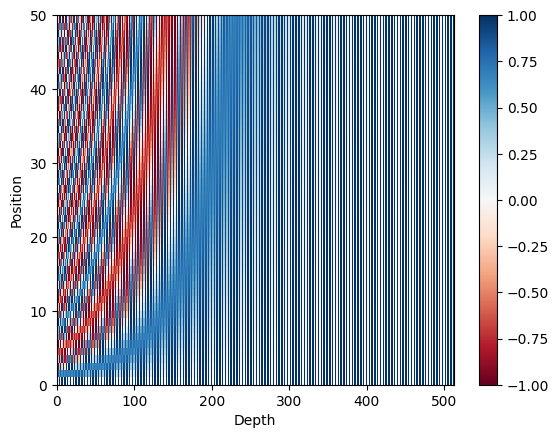

In [109]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 5.6. Masking
*Masking* digunakan untuk memastikan bahwa model tidak memproses padding pada input. Mask menunjukkan bahwa jika pad value `0`: maka outputnya adalah  `1` pada lokasi-lokasi tersebut, dan `0` jika sebaliknya.

In [110]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [111]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

 Dengan kata lain, masking menunjukkan item mana yang tidak boleh digunakan (karena padding).

Artinya, untuk memprediksi kata ketiga, hanya kata pertama dan kedua yang akan digunakan. Demikian pula untuk memprediksi kata keempat, hanya kata pertama, kedua dan ketiga yang akan digunakan dan seterusnya. Masking menandai item padding yang tidak digunakan dalam prediksi.

In [112]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [113]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# **6. Scaled Dot Product Attention**

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Fungsi atensi yang digunakan pada Transformer menerima 3 input yaitu: Q (query), K (key), V (value). Persamaan berikut digunakan untuk menghitung bobot atensi (attention weight):

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Dot-product attention di-skala menggunakan faktor dari kuadrat kedalaman (factor of square root of depth). Hal ini dilakukan karena untuk nilai kedalaman yang besar, dot product bertambah besar besar, mendorong fungsi softmax yang memiliki gradien kecil sehingga menghasilkan softmax yang sangat keras.

Sebagai contoh, jika `Q` and `K` memiliki rata-rata 0 and varian 1,  maka matrix multiplication (matmul) akan memiliki rata-rata 0 dan variansi `dk`. Sehingga, *square root of `dk`* digunakan untuk scaling karena matmul dari `Q` and `K` memiliki rata-rata 0 dan varians 1, dan yaitu softmax yang lebih halus.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

Mask dikalikan dengan -1e9 (mendekati infinity negatif). Hal ini dilakukan karena mask dijumlahkan dengan perkalian matriks skala Q dan K dan diterapkan segera sebelum softmax. Tujuannya adalah untuk menghilangkan sel-sel ini, dan input negatif besar ke softmax mendekati nol pada output.

In [114]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Karena normalisasi softmax dilakukan pada K, nilainya menentukan jumlah kepentingan yang diberikan kepada Q.

Outputnya mewakili perkalian bobot atensi (attention weight) dan vektor V (nilai). Ini memastikan bahwa kata-kata yang ingin Anda fokuskan tetap apa adanya dan kata-kata yang tidak relevan dihilangkan.

In [115]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [116]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [117]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [118]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Masukkan semua query (temp_q, temp_k, temp_v).

In [119]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# **7. Multi Head Attention**

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention terdiri atas empat bagian:
*   Layer-layer linier dan masing-masig menjadi head.
*    Scaled dot-product attention.
*    Concatenation of heads (gabungan dari beberapa head).
*    Final linear layer.

Setiap multi-head attention memiliki 3 buah input; Q (query), K (key), V (value). Input-input tersebut diberikan pada (Dense) layers dan dipecah menjadi beberapa head.

Setelah dibagi menjadi beberapa head, pada setiap head dilakukan dimensionality reduction untuk mengurangi beban komputasi.

 `Scaled_dot_product_attention` diaplikasikan pada setiap head (broadcasted). Mask yang tepat harus digunakan pada setiap layer Atensi.  Luaran (output) atensi untuk setiap head kemudian digabungkan (using `tf.transpose`, and `tf.reshape`) kemudian dimasukkan dalam  `Dense` layer final.



In [120]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Kita kan mencoba membuat `MultiHeadAttention` layer. Pada setiap lokasi di dalam sequence input, `y`, `MultiHeadAttention` terdiri dari 8  heads pada posisi-posisi lain di dalam sequence, menghasilkan vektor berukuran sama pada setiap lokasi di sequence.

In [121]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# **8. Point wise feed forward network**
Dense Layer (Point Wise Feed Forward Neural Network)

Setelah MultiHeadAttention kita menggunakan Dense Layer (Point wise Feed Forward Neural Network) dengan fungsi aktivasi RelU

In [122]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [123]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# **9. Membangun Encoder dan Decoder**

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Model transformer mengikuti standar model berbasi sequence to sequence yaitu menggunakan Encoder dan Decoder.

* Kalimat input  dimasukkan dalam `N` encoder layers yang menghasilkan output untuk setiap word/kata/token pada kalimat input
* The decoder menggunakan output dari encoder dan input decoder itu sendiri (yang berasal dari self-attention) untuk memprediksi kata selanjutnya.

## **9.1 Encoder Layer**

Setiap layer pada encoder terdiri dari sub-sub layer:

1.   Multi-head attention (with padding mask)
2.    Point wise feed forward networks.

Setiap sublayers memiliki sebuah *residual connection* dan diikuti layer normalisasi. *Residual connections* membantu mencegah Vanishing Gradient Problem.

Output dari setiap sublayer yaitu `LayerNorm(x + Sublayer(x))`. Normalisasi dilakukan pada `d_model`. Terdapat N encoder layers pada transformer.

In [124]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [125]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## **9.2 Decoder Layer**

Setiap decoder layer terdiri dari sub-sub layer:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Setiap sublayer ini memiliki sebuah residual connection diikuti dengan layer normalisasi. Output dari setiap sublayer adalah `LayerNorm(x + Sublayer(x))`. Normalisasi dilakukan pada `d_model` .

Terdapat N decoder layers pada model transformer.

KArena Q menerima output dari Blok Attention pertama pada Decoder, dan K menerima luaran dari encoder, bobot atensi menunjukkan kepentingan yang diberikan kepada input Decoder berdasarkan Output dari Encoder.

Dengan kata lain decoder memprediksi kata berikutnya dengan melihat output encoder dan memperhatikan outputnya sendiri.

In [126]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [127]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## **9.3 Encoder**

`Encoder` Terdiri dari:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

Input pada Encoder layer adalah penjumlahan (summation) dari output layer Embedding dan output dari Positional Encoding

In [128]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [129]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## **9.4 Decoder**

`Decoder` Terdiri atas:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers



In [130]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [131]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# **10. Membangun Model Transformer**

Transformer terdiri dari encoder, decoder dan  linear layer final.

In [132]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [133]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## **10.1 Set hyperparameters**
Mengeset Hyperparameter yang sesuai

Agar modelnya tetap kecil dan cukup cepat trainingnya, pada praktikum ini  *num_layers, d_model, and dff* sudah diperkecil (dibandigkan aslinya Transformer).

Aslinya; *num_layers=6*, *d_model = 512*, *dff = 2048*. Lihat [paper](https://arxiv.org/abs/1706.03762) .



In [134]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## **10.2 Optimizer**

Gunakan Adam optimizer untuk melakukan optimasi
$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [135]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [140]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate(40.0), beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

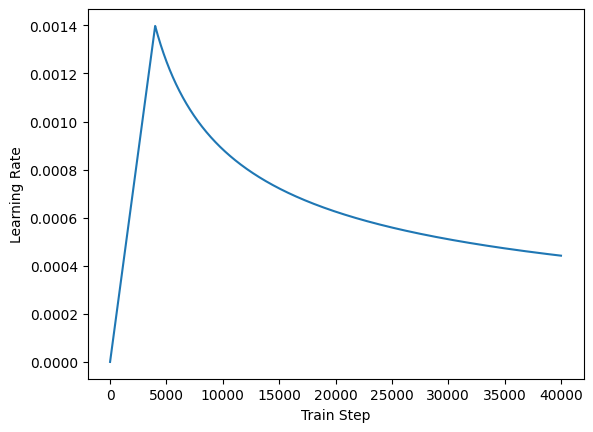

In [141]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## **10.3 Loss and metrics**
Perhitungan Loss dan Metrics

Karena ukuran kalimat input berbeda2 maka diperlukan padding dan perlu mengapply padding untuk perhitungan loss dan metrics (accuracy)

In [142]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [143]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [144]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## **10.4 Training Model Transformer**

In [145]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [146]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

Karena training model Transformer akan berlangsung lama, maka kita gunakan checkpoint supaya modelnya tersimpan jika koneksi terputus.

In [147]:
checkpoint_path = root_path # + "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Target dibedakan menjadi tar_inp dan tar_real. tar_inp diberikan sebagai input kepada Decoder. `tar_real` sebenarnya sama dengan tar_inp hanya digeser 1 posisi: pada setiap posisi pada `tar_input`, `tar_real` berisi kata yang harus diprediksi sesudahnya.

Contoh, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Model transformer bersifat auto-regressive yaitu membuat satu prediksi dalam satu waktu, dan menggunakan output prediksi tersebut untuk menentukan what's next.

karena Transformer memprediksi setiap kata, *self-attention* memungkinkan model untuk melihat kata sebelum untuk memprediksi kata sesudah.

Untuk mencegah model mengintip output yang diharapkan, model menggunakan masking  ke depan.

In [148]:
#EPOCHS = 20
EPOCHS = 5

In [149]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

Bahasa Portugis digunakan sebagai input dan bahasa inggris digunakan sebagai output.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0021 Accuracy 0.0008
Epoch 1 Batch 50 Loss 8.8910 Accuracy 0.0094
Epoch 1 Batch 100 Loss 8.8228 Accuracy 0.0181
Epoch 1 Batch 150 Loss 8.7697 Accuracy 0.0216
Epoch 1 Batch 200 Loss 8.7239 Accuracy 0.0235
Epoch 1 Batch 250 Loss 8.6793 Accuracy 0.0249
Epoch 1 Batch 300 Loss 8.6360 Accuracy 0.0262
Epoch 1 Batch 350 Loss 8.5927 Accuracy 0.0276
Epoch 1 Batch 400 Loss 8.5499 Accuracy 0.0290
Epoch 1 Batch 450 Loss 8.5074 Accuracy 0.0302
Epoch 1 Batch 500 Loss 8.4653 Accuracy 0.0314
Epoch 1 Batch 550 Loss 8.4234 Accuracy 0.0324
Epoch 1 Batch 600 Loss 8.3815 Accuracy 0.0334
Epoch 1 Batch 650 Loss 8.3395 Accuracy 0.0346
Epoch 1 Batch 700 Loss 8.2986 Accuracy 0.0358
Epoch 1 Loss 8.2970 Accuracy 0.0358
Time taken for 1 epoch: 799.4745299816132 secs

Epoch 2 Batch 0 Loss 7.6734 Accuracy 0.0509
Epoch 2 Batch 50 Loss 7.6854 Accuracy 0.0543
Epoch 2 Batch 100 Loss 7.6515 Accuracy 0.0557
Epoch 2 Batch 150 Loss 7.6134 Accuracy 0.0565
Epoch 2 Batch 200 Loss 7.5782 Accuracy 0.0573
Ep

# **11. Evaluasi Model**

Lakukan langkah-langkah berikut ini untuk evaluasi:

* Encode setiap kalimat input dalam Portugis mengguankan Tokenizer (`tokenizer_pt`). Lebih lanjut, Tambahkan penanda awal (start) dan akhir (end) (seperti pada training).
* Input pada decoder yaitu `start token == tokenizer_en.vocab_size`.
* Lakukan masking.
*  `decoder` mengeluarkan output berdasarkan `encoder output` dan input decoder (self-attention).
* Pilih kata terakhir dan hitung argmaxnya.
*Gabungkan (concatenate) kata yang diprediksi ke input Decoder saat meneruskannya ke Decoder.
* Dalam pendekatan ini, decoder memprediksi kata berikutnya berdasarkan kata-kata sebelumnya yang diprediksinya.



In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]

  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'],
        fontdict=fontdict, rotation=90)

    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                        if i < tokenizer_en.vocab_size],
                       fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode([i for i in result
                                            if i < tokenizer_en.vocab_size])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

In [ ]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

# **Summary**

Dalam praktikum ini, Anda belajar tentang positional encoding, multihead attention, masking dan cara membuat model transformator.


# **POST TEST:**

Ubahlah epoch dengan menaikkan angkanya dari 5 menjadi 8 kemudian 10. Lihat bagaimana pengaruhnya terhadap akurasi dan loss. Apakah akurasi naik dan loss berkurang dengan kenaikan epoch?

Ubahlah nilai-nilai hyperparameter:
- jumlah head menjadi 16
- jumlah layer menjadi 10
Perhatikan apakah hal ini menaikkan akurasi?